In [1]:
import csv
import requests
import sys
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fft, fftfreq

from datetime import datetime, timezone
from prometheus_api_client import PrometheusConnect

from prometheus_pandas import query

import numpy as np
import pandas as pd

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#read from prometheus or disk
fromDisk=False
localFile="data.pickle"

## Load Data
from the desired data source

In [3]:
if fromDisk:
    df = pd.read_pickle(localFile)
    
else:
    prometheus_url = 'http://jmeyer-misc:9090'
    p = query.Prometheus(prometheus_url)
    df = p.query('temperature[90d]')
    
    df.to_pickle(localFile)

In [4]:
#rename columns for easier visualization
df.rename(columns={
    df.columns[0]: '1', 
    df.columns[1]: '2',
    df.columns[2]: '3',
    df.columns[3]: '4',
    df.columns[4]: '5',
    df.columns[5]: '6',
    df.columns[6]: '7',
}, inplace=True)

In [5]:
df.reset_index()
df

1            2     3     4     5     6     7
2023-04-09 12:00:32.104000092  17.3 -214748364.7  13.8  18.8  18.2  23.5  16.4
2023-04-09 12:01:32.104000092  17.4 -214748364.7  13.8  18.8  18.2  23.6  16.4
2023-04-09 12:02:32.104000092  17.4 -214748364.7  13.8  18.8  18.2  23.6  16.4
2023-04-09 12:03:32.104000092  17.4 -214748364.7  13.9  18.8  18.2  23.6  16.4
2023-04-09 12:04:32.104000092  17.4 -214748364.7  13.9  18.8  18.2  23.6  16.4
...                             ...          ...   ...   ...   ...   ...   ...
2023-04-24 20:10:39.835999966  16.7 -214748364.7  16.4  22.5  19.4  27.9  18.9
2023-04-24 20:11:39.835999966  16.7 -214748364.7  16.2  22.5  19.1  27.3  18.9
2023-04-24 20:12:39.835999966  16.5 -214748364.7  16.2  22.2  19.0  27.3  18.7
2023-04-24 20:13:39.835999966  16.5 -214748364.7  16.2  22.2  19.0  27.3  18.7
2023-04-24 20:14:39.835999966  16.4 -214748364.7  15.9  22.0  19.0  27.0  18.7

[19132 rows x 7 columns]

## Light data cleaning
of known bad values when a temperature sensor is not responding.  A large negative value represents a failure.  This is simply dumping these

In [6]:
df = df[df > -100]

<AxesSubplot:>

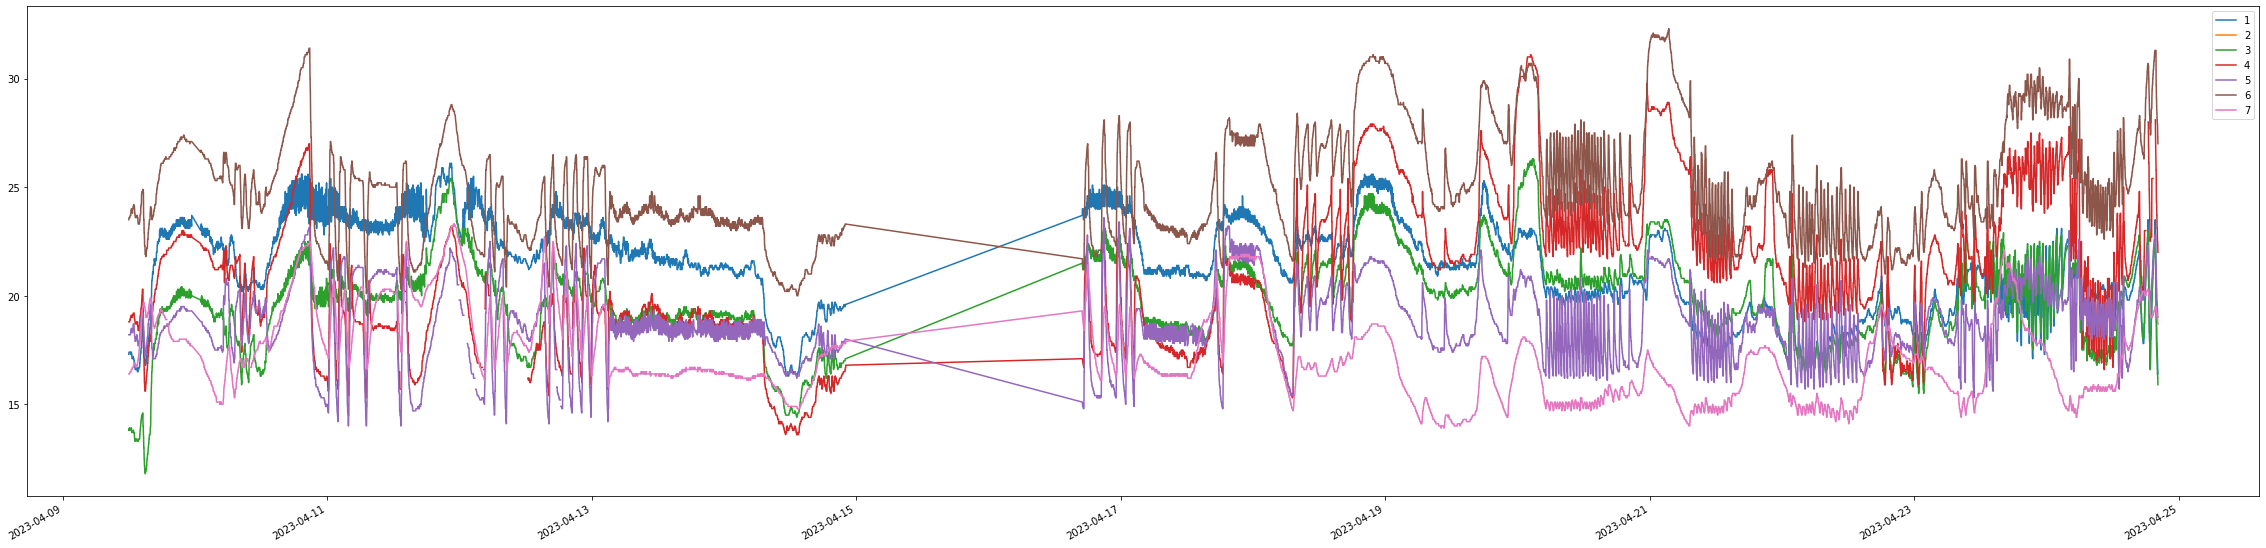

In [7]:
df.plot(kind='line',figsize=(40,10))

In [8]:
# look at a good segment of sawtooth
seg_pd = df.loc['2023-04-20'][0:1000]


<AxesSubplot:>

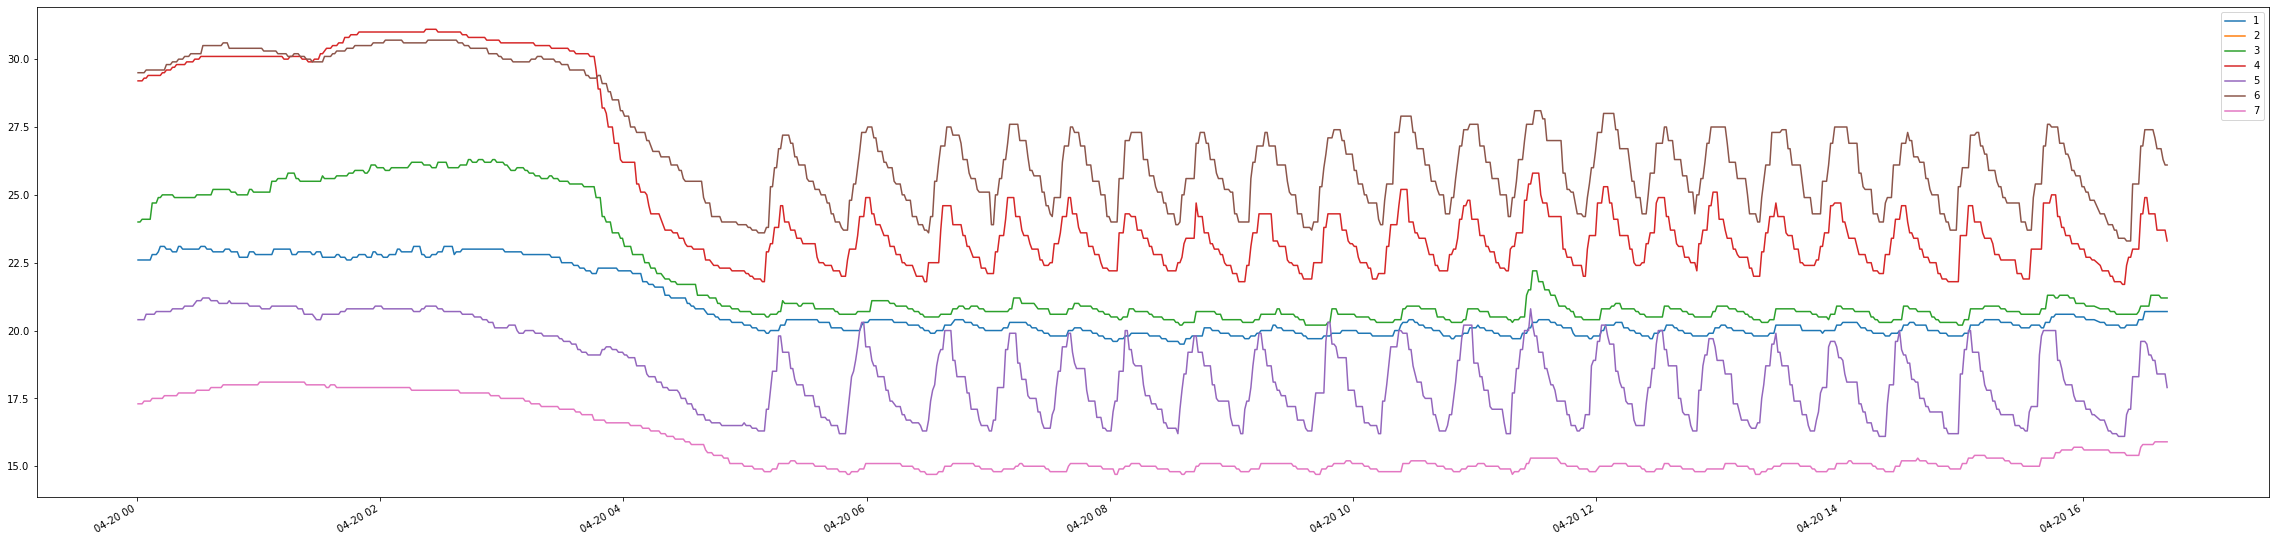

In [9]:
seg_pd.plot(kind='line',figsize=(40,10))

In [10]:
signal = seg_pd['7'].values
#print(signal)
    

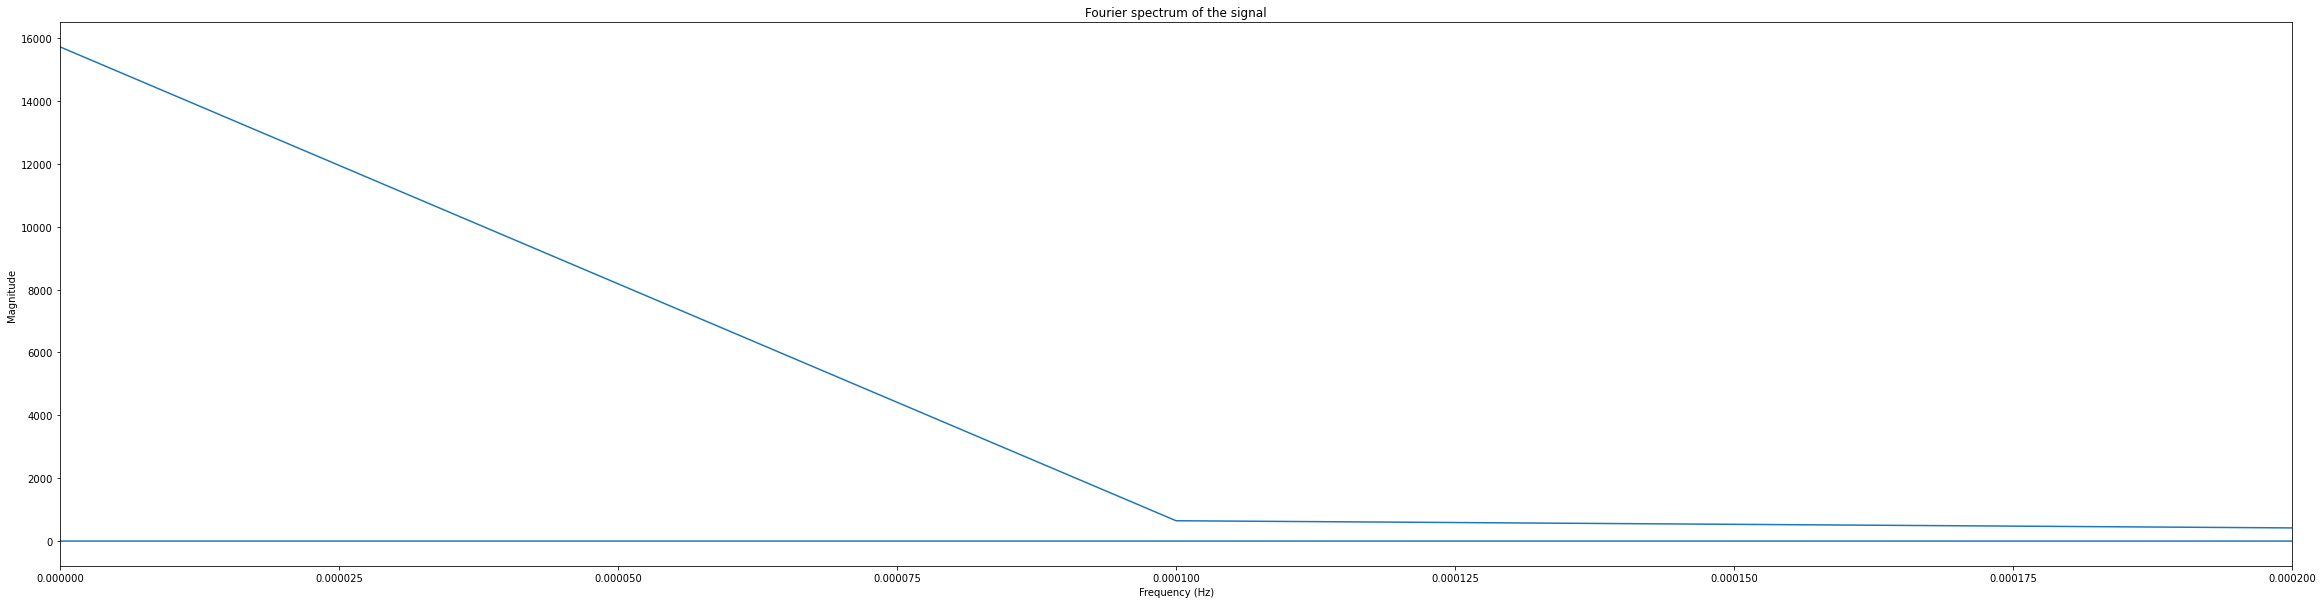

In [11]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    return unique_list


# Perform Fourier analysis


sample_rate = .1
fft_signal = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), 1/sample_rate)
fft_signal_abs = np.abs(fft_signal)



# Plot the Fourier spectrum
plt.figure(figsize=(40, 10))
plt.plot(freqs, fft_signal_abs)
# plt.xlim(0, fs/2)
plt.title('Fourier spectrum of the signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.ylim(0, 200)
plt.xlim(left=0, right=.0002)
plt.show()


## switching eample
using a scipy method from https://realpython.com/python-scipy-fft/

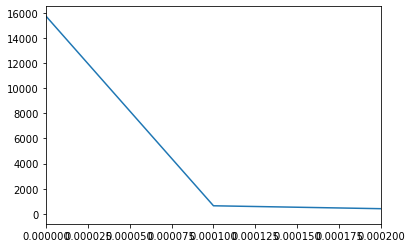

In [12]:
from scipy.fft import rfft, rfftfreq

#rfft means real number fft

#

sample_rate = .1
N = int(sample_rate)

yf = rfft(signal)
xf = rfftfreq(len(signal), 1 / sample_rate)

yf = yf[0:len(xf)]

plt.plot(xf, np.abs(yf))
plt.xlim(left=0, right=.0002)
plt.show()

In [13]:
#np.abs(yf)

what do the first 10 values of this realfft look like?

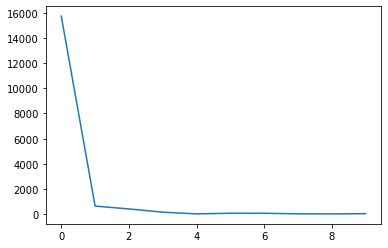

In [14]:
plt.plot(np.abs(yf)[0:10])
plt.show()

### examine a single point

lets look at a single pen and sweep the FFT across it

<AxesSubplot:>

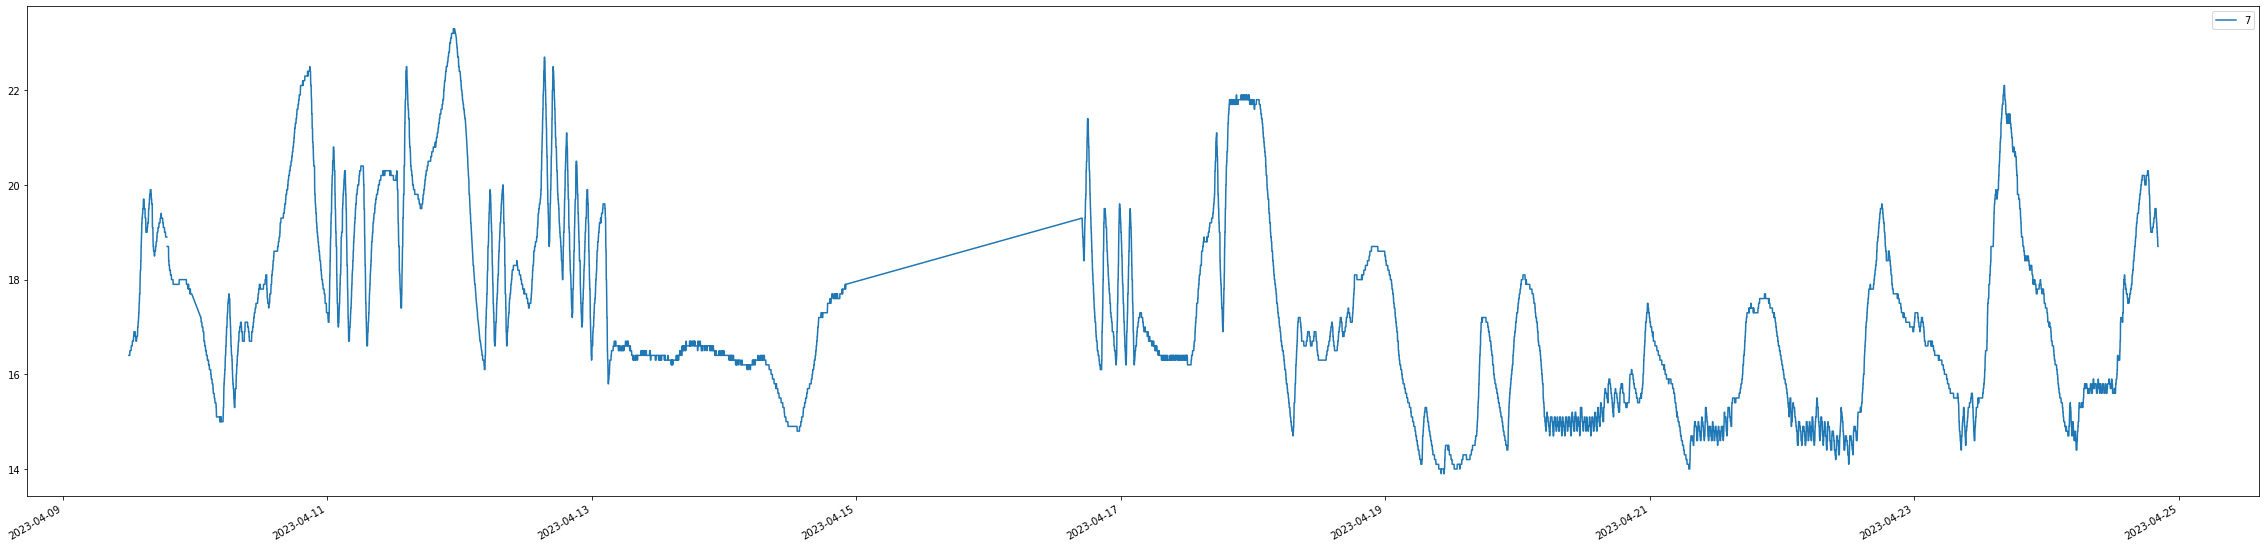

In [15]:
adf = df[['7']]
adf.plot(kind='line',figsize=(40,10))

In [16]:
len(adf)

19132

In [17]:
window_sample_size = 50

sma_values = [0] * window_sample_size

for i in range(window_sample_size,len(adf)):
    #adf.loc[i, 'sma'] = adf.iloc[i-window_sample_size: i].mean()
    #print( adf.iloc[i-window_sample_size: i].mean())
    v = adf.iloc[i-window_sample_size: i]['7'].mean()
    sma_values.append(float(v))
    #adf.insert(i, 'SMA', 16)

adf.insert(loc=1, column="sma", value=sma_values)

In [18]:
adf

7     sma
2023-04-09 12:00:32.104000092  16.4   0.000
2023-04-09 12:01:32.104000092  16.4   0.000
2023-04-09 12:02:32.104000092  16.4   0.000
2023-04-09 12:03:32.104000092  16.4   0.000
2023-04-09 12:04:32.104000092  16.4   0.000
...                             ...     ...
2023-04-24 20:10:39.835999966  18.9  19.284
2023-04-24 20:11:39.835999966  18.9  19.280
2023-04-24 20:12:39.835999966  18.7  19.276
2023-04-24 20:13:39.835999966  18.7  19.268
2023-04-24 20:14:39.835999966  18.7  19.260

[19132 rows x 2 columns]

<AxesSubplot:>

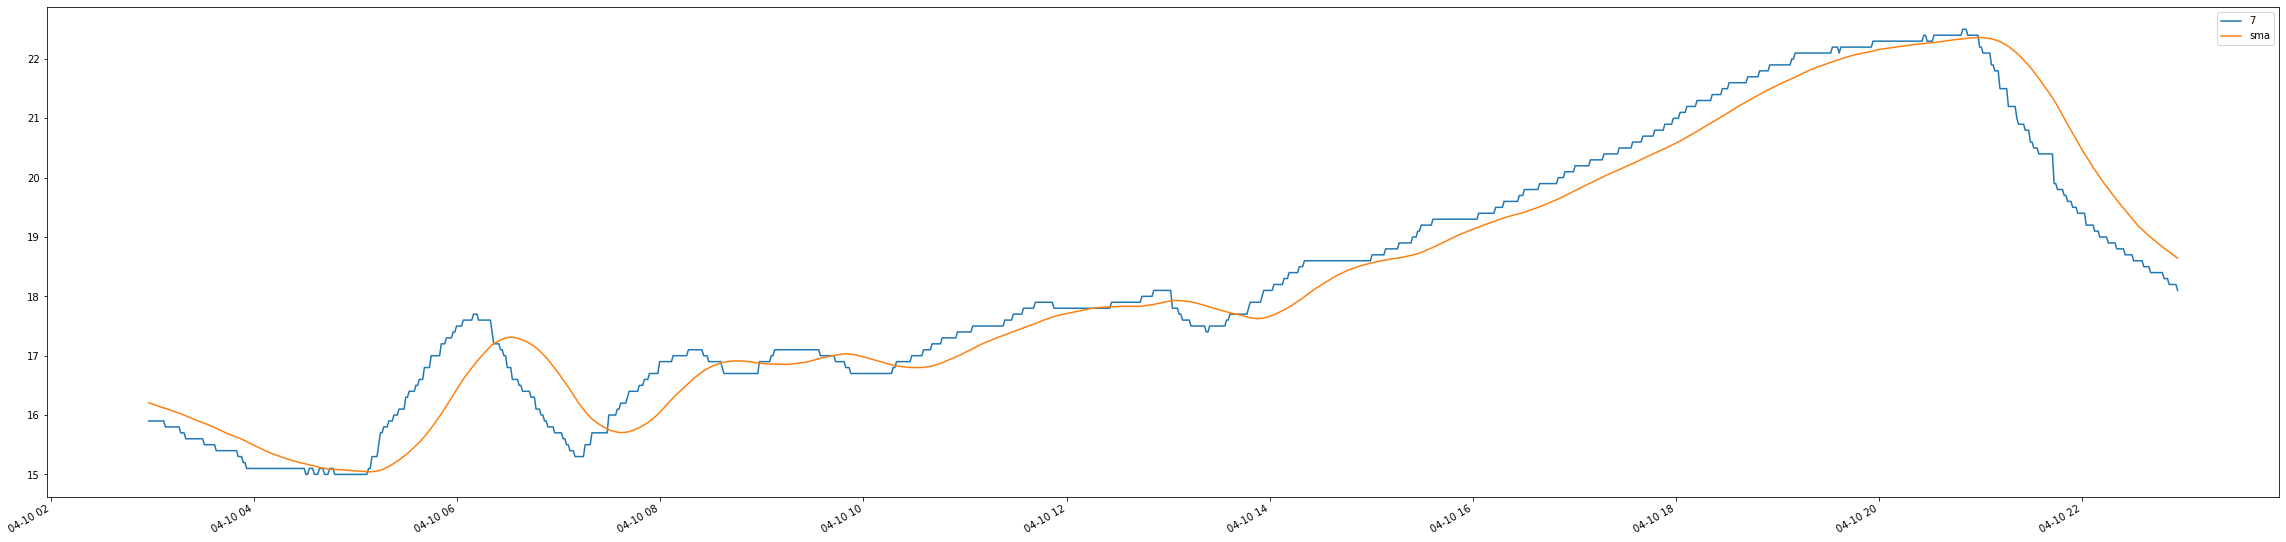

In [19]:
adf.iloc[800:2000].plot(kind='line',figsize=(40,10))

In [20]:
df[['7']].values

array([[16.4],
       [16.4],
       [16.4],
       ...,
       [18.7],
       [18.7],
       [18.7]])

In [21]:

adf = df[['7']]


window_sample_size = 100

sma_values = [0] * window_sample_size
fft_values = [0] * window_sample_size

for i in range(window_sample_size,len(adf)):
    #adf.loc[i, 'sma'] = adf.iloc[i-window_sample_size: i].mean()
    #print( adf.iloc[i-window_sample_size: i].mean())
    v = adf.iloc[i-window_sample_size: i]['7'].mean()
    sma_values.append(float(v))
    yf = rfft(adf.iloc[i-window_sample_size: i]['7'].values)
    
    fft_values.append(yf[2].real)

adf.insert(loc=1, column="sma", value=sma_values)
adf.insert(loc=1, column="fft", value=fft_values)

<AxesSubplot:>

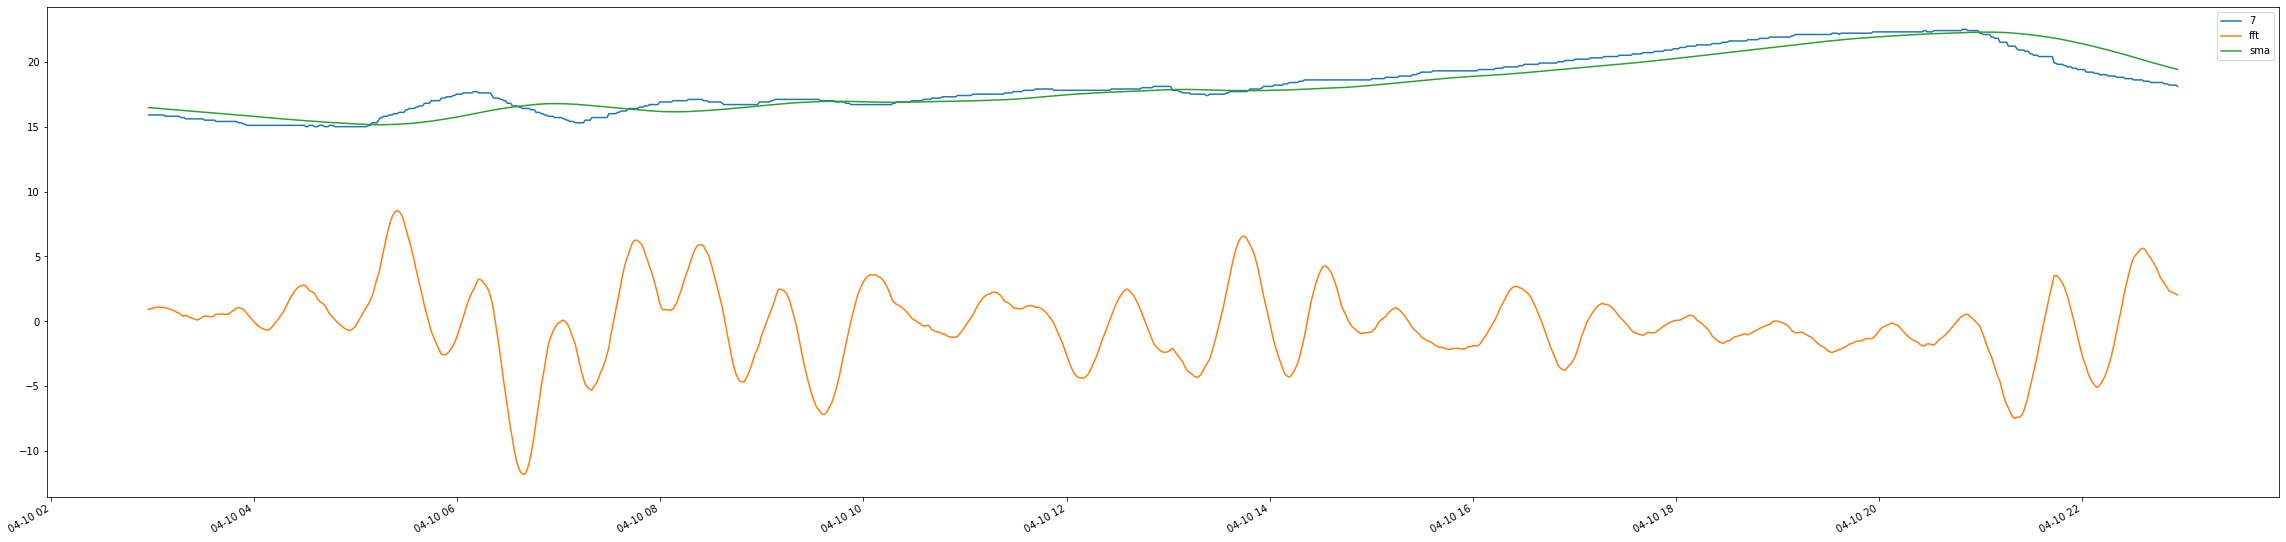

In [22]:
adf.iloc[800:2000].plot(kind='line',figsize=(40,10))

In [23]:
adf = df[['7']]


window_sample_size = 100

sma_values = [0] * window_sample_size
fft_values = [0] * window_sample_size

for i in range(window_sample_size,len(adf)):
    #adf.loc[i, 'sma'] = adf.iloc[i-window_sample_size: i].mean()
    #print( adf.iloc[i-window_sample_size: i].mean())
    v = adf.iloc[i-window_sample_size: i]['7'].mean()
    sma_values.append(float(v))
    yf = rfft(adf.iloc[i-window_sample_size: i]['7'].values)
    
    fft_values.append(yf[2].real)

adf.insert(loc=1, column="sma", value=sma_values)
adf.insert(loc=1, column="fft", value=np.abs(fft_values))


<AxesSubplot:>

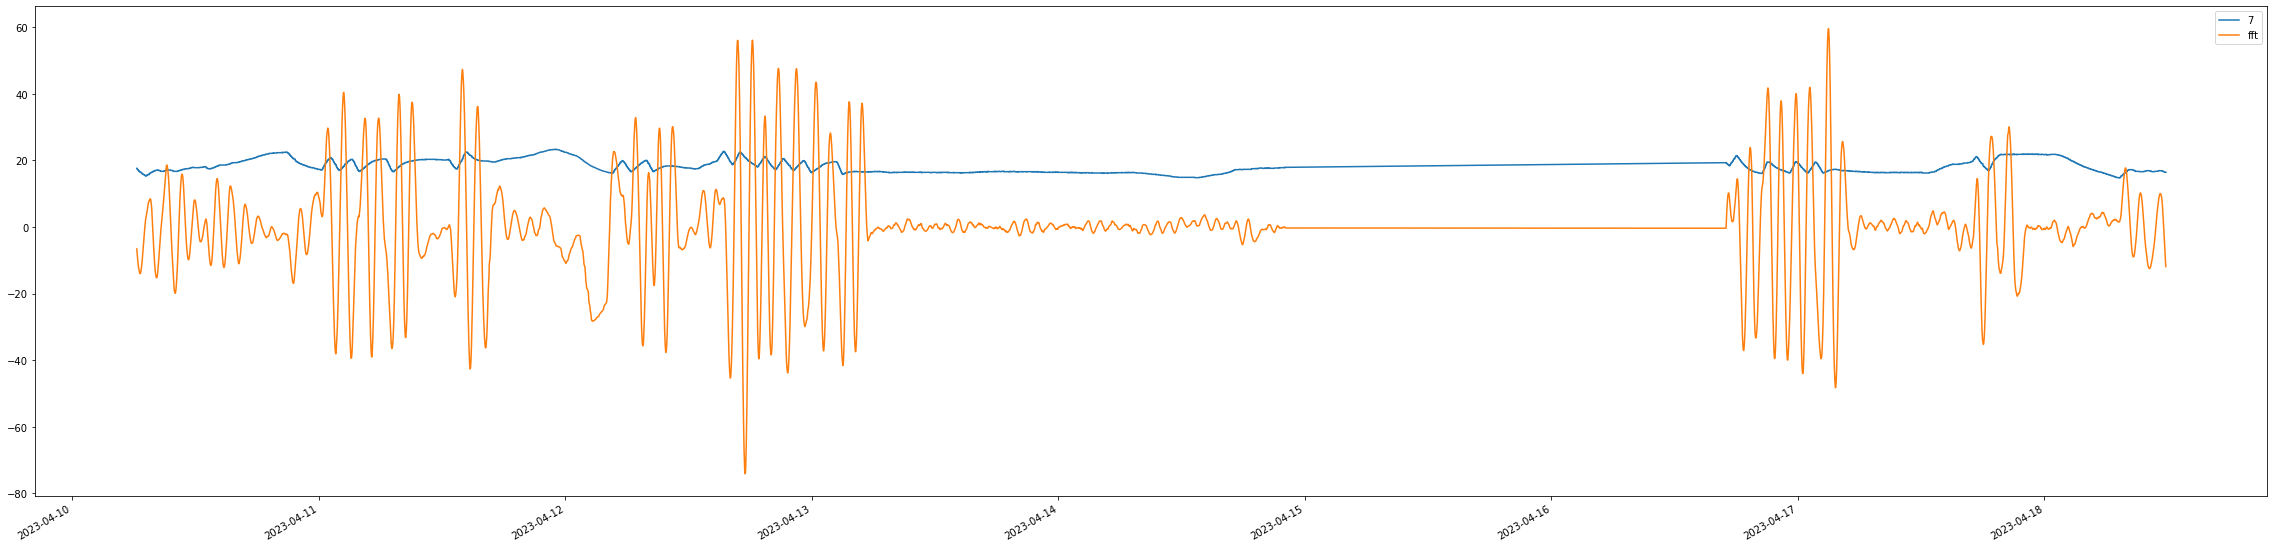

In [24]:
adf = df[['7']]


window_sample_size = 150

fft_values = [0] * window_sample_size

for i in range(window_sample_size,len(adf)):
    #adf.loc[i, 'sma'] = adf.iloc[i-window_sample_size: i].mean()
    #print( adf.iloc[i-window_sample_size: i].mean())
    v = adf.iloc[i-window_sample_size: i]['7'].mean()
    sma_values.append(float(v))
    yf = rfft(adf.iloc[i-window_sample_size: i]['7'].values)
    
    fft_values.append(yf[2].real)


adf.insert(loc=1, column="fft", value=fft_values)

adf.iloc[1000:10000].plot(kind='line',figsize=(40,10))

<AxesSubplot:>

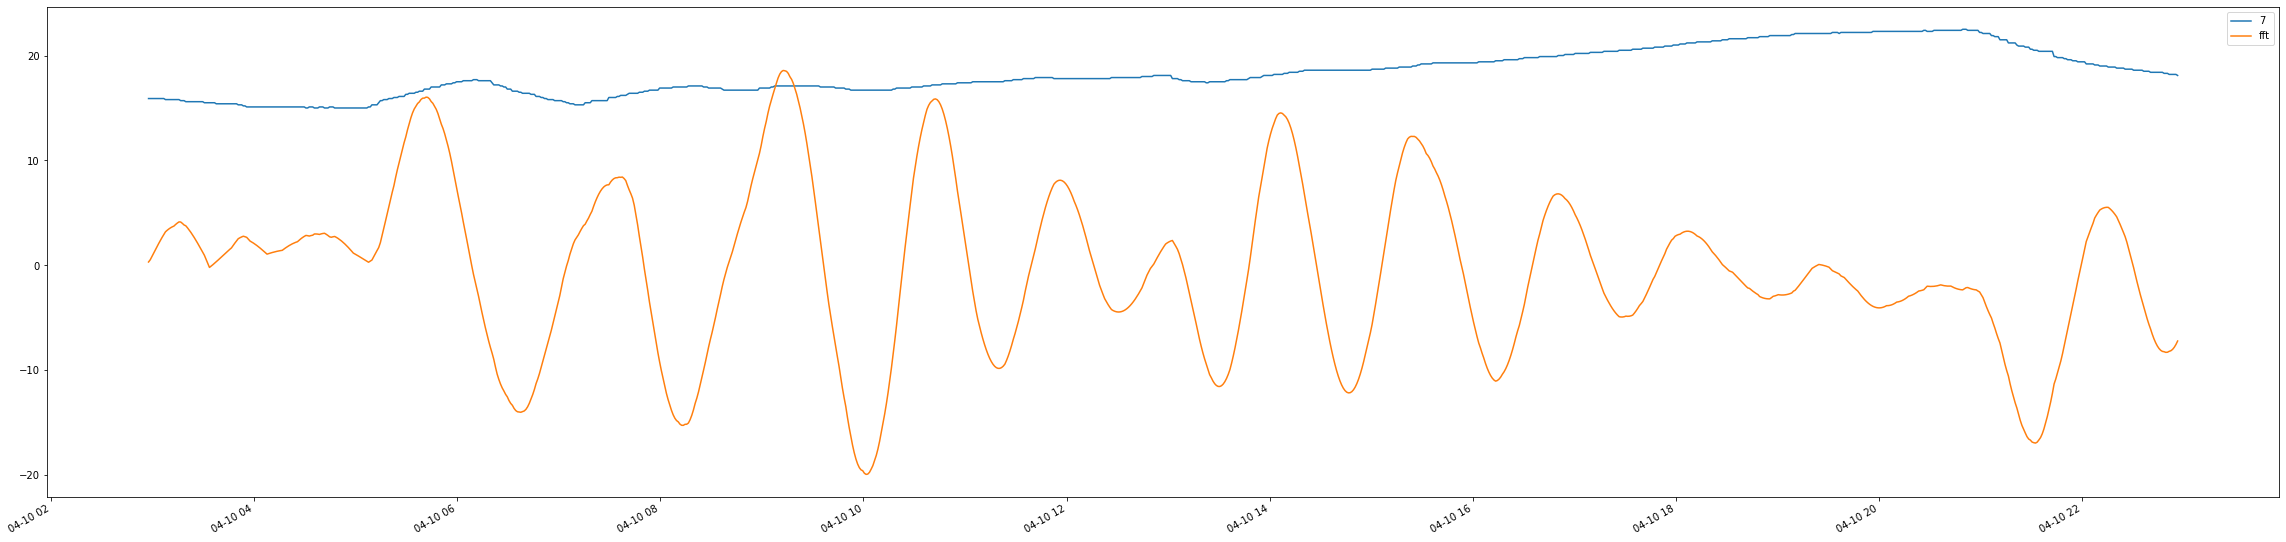

In [25]:
adf.iloc[800:2000].plot(kind='line',figsize=(40,10))

### testing thing

<AxesSubplot:>

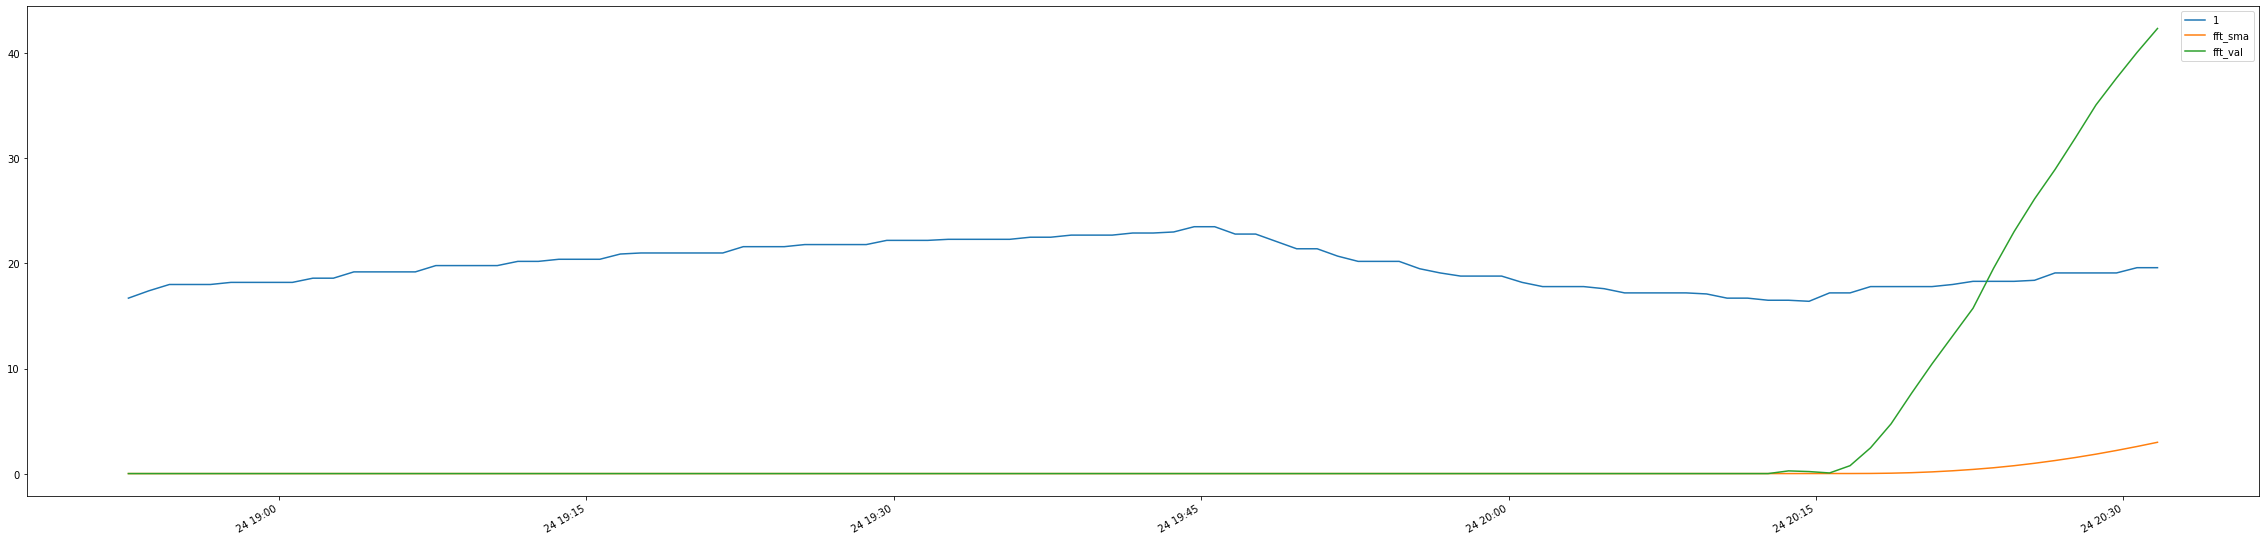

In [55]:
COL = '1'
adf = df[[COL]]


window_sample_size = 100

sma_values = [0] * window_sample_size
fft_values = [0] * window_sample_size
fft_smaval = [0] * window_sample_size

for i in range(window_sample_size,len(adf)):
    #adf.loc[i, 'sma'] = adf.iloc[i-window_sample_size: i].mean()
    #print( adf.iloc[i-window_sample_size: i].mean())
    v = adf.iloc[i-window_sample_size: i][COL].mean()
    sma_values.append(float(v))
    #
    yf = rfft(adf.iloc[i-window_sample_size: i][COL].values)
    #print(type(adf.iloc[i-window_sample_size: i]['7'].values))
    #print(adf.iloc[i-window_sample_size: i]['7'].values)
    fft_values.append(abs(yf[2].real))
    #
    fft_smaval.append(np.mean(fft_values[i-window_sample_size:i]))

#adf.insert(loc=1, column="sma", value=sma_values)
#adf.insert(loc=1, column="fft", value=fft_values)
adf.insert(loc=1, column="fft_sma", value=fft_smaval)
adf.insert(loc=2, column="fft_val", value=fft_values)

adf.iloc[-100:].plot(kind='line',figsize=(40,10))

In [27]:
adf.iloc[i-window_sample_size: i]

7   fft_sma   fft_val
2023-04-24 18:34:39.835999966  20.1  1.767456  1.779638
2023-04-24 18:35:39.835999966  20.1  1.769685  2.376687
2023-04-24 18:36:39.835999966  20.1  1.778327  2.939409
2023-04-24 18:37:39.835999966  20.0  1.793120  3.458928
2023-04-24 18:38:39.835999966  20.0  1.812713  4.125475
...                             ...       ...       ...
2023-04-24 20:09:39.835999966  18.9  4.731367  1.737305
2023-04-24 20:10:39.835999966  18.9  4.742787  1.737201
2023-04-24 20:11:39.835999966  18.9  4.757526  1.819952
2023-04-24 20:12:39.835999966  18.7  4.773948  1.884251
2023-04-24 20:13:39.835999966  18.7  4.786585  1.730663

[100 rows x 3 columns]

### from live

In [58]:
prometheus_url = 'http://jmeyer-misc:9090'
p = query.Prometheus(prometheus_url)
# going to use 2h to roughly base this off the success found with 100 data samples
# fft is not timeseries data aware
df = p.query('temperature[120m]') #roughly 100 values (needed)

df.rename(columns={
    df.columns[0]: '1',
    df.columns[1]: '2',
    df.columns[2]: '3',
    df.columns[3]: '4',
    df.columns[4]: '5',
    df.columns[5]: '6',
    df.columns[6]: '7',
}, inplace=True)

#data cleaning
df = df[df > -100]


window_sample_size = df.shape[0] #should have about 100 samples to examine

ret = [0.0] * 7

for i in range(1,8):
    col = str(i)
    yf = rfft(df.iloc[-window_sample_size:][[col]].values.flatten())
    #yf = rfft(adf.iloc[i-window_sample_size: i]['7'].values)
    #print(type(df.iloc[-100:][[col]].values.flatten()))
    #print(df.iloc[-100:][[col]].values.flatten())
    ret[i-1] = abs(yf[2].real) # the 2nd sample is key here, packed in an array hence the [0]

print("len")
print(df.shape)
print(ret)

len
(120, 7)
[84.3917836904127, nan, 86.90971790066831, nan, 51.520240218267844, 55.762880001544836, 11.020521483852235]


In [29]:
df.iloc[-100:]

1   2     3     4     5     6     7
2023-04-24 18:36:39.835999966  19.7 NaN  20.3  26.1  21.2  29.5  20.1
2023-04-24 18:37:39.835999966  19.7 NaN  19.0  26.1  20.8  29.5  20.0
2023-04-24 18:38:39.835999966  19.0 NaN  19.0  24.9  20.8  29.3  20.0
2023-04-24 18:39:39.835999966  19.0 NaN  18.3  24.9  20.8  29.3  19.8
2023-04-24 18:40:39.835999966  19.0 NaN  18.3  24.9  20.8  28.9  19.8
...                             ...  ..   ...   ...   ...   ...   ...
2023-04-24 20:11:39.835999966  16.7 NaN  16.2  22.5  19.1  27.3  18.9
2023-04-24 20:12:39.835999966  16.5 NaN  16.2  22.2  19.0  27.3  18.7
2023-04-24 20:13:39.835999966  16.5 NaN  16.2  22.2  19.0  27.3  18.7
2023-04-24 20:14:39.835999966  16.4 NaN  15.9  22.0  19.0  27.0  18.7
2023-04-24 20:15:39.835999966  17.2 NaN  17.1  22.0  18.9  27.0  18.6

[100 rows x 7 columns]

<AxesSubplot:>

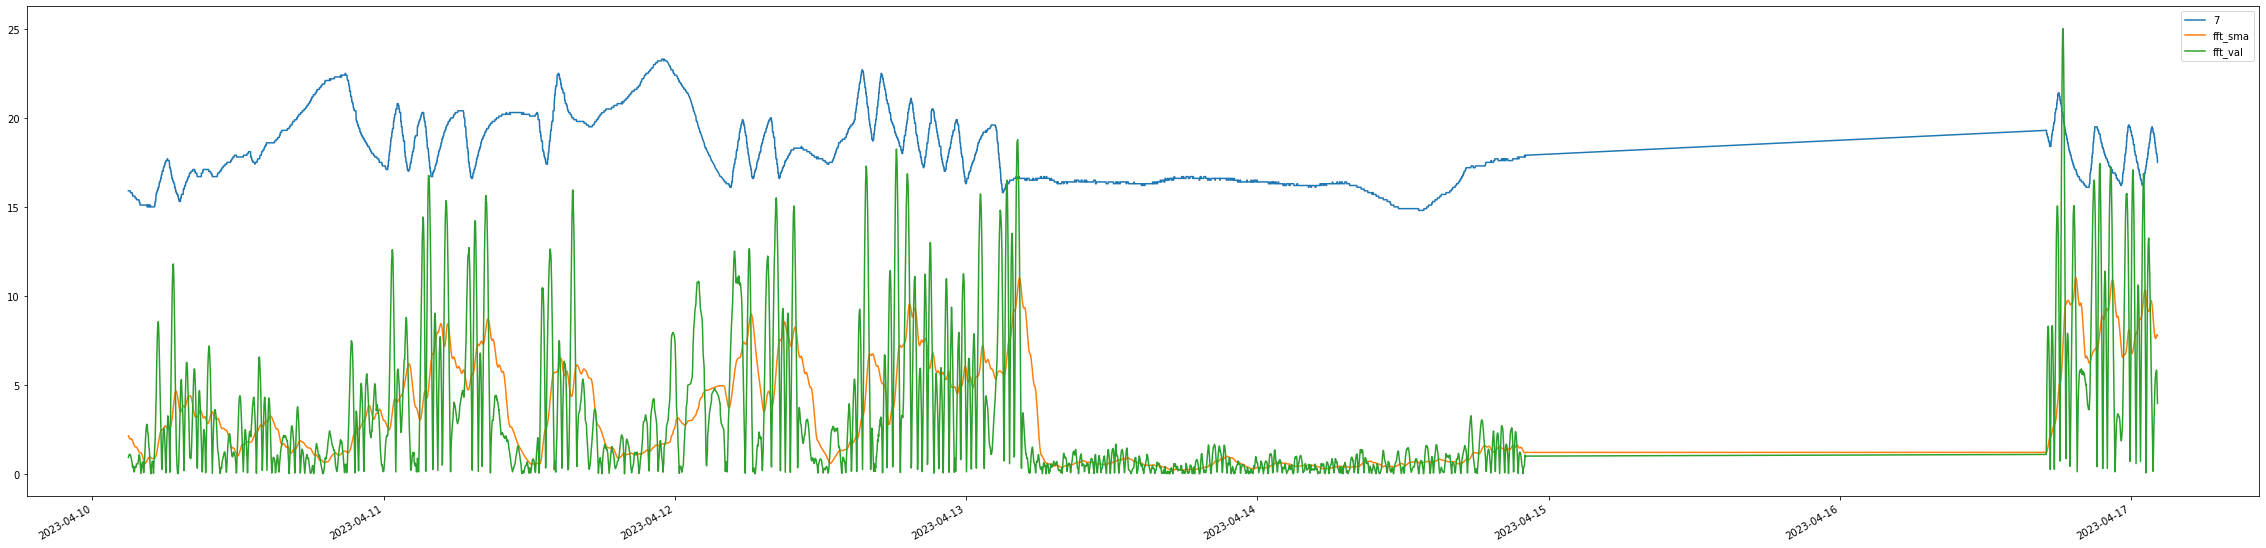

In [30]:
adf.iloc[800:8000].plot(kind='line',figsize=(40,10))

In [31]:
adf.insert(loc=1, column="limit", value=[8] * len(adf['7']))


<AxesSubplot:>

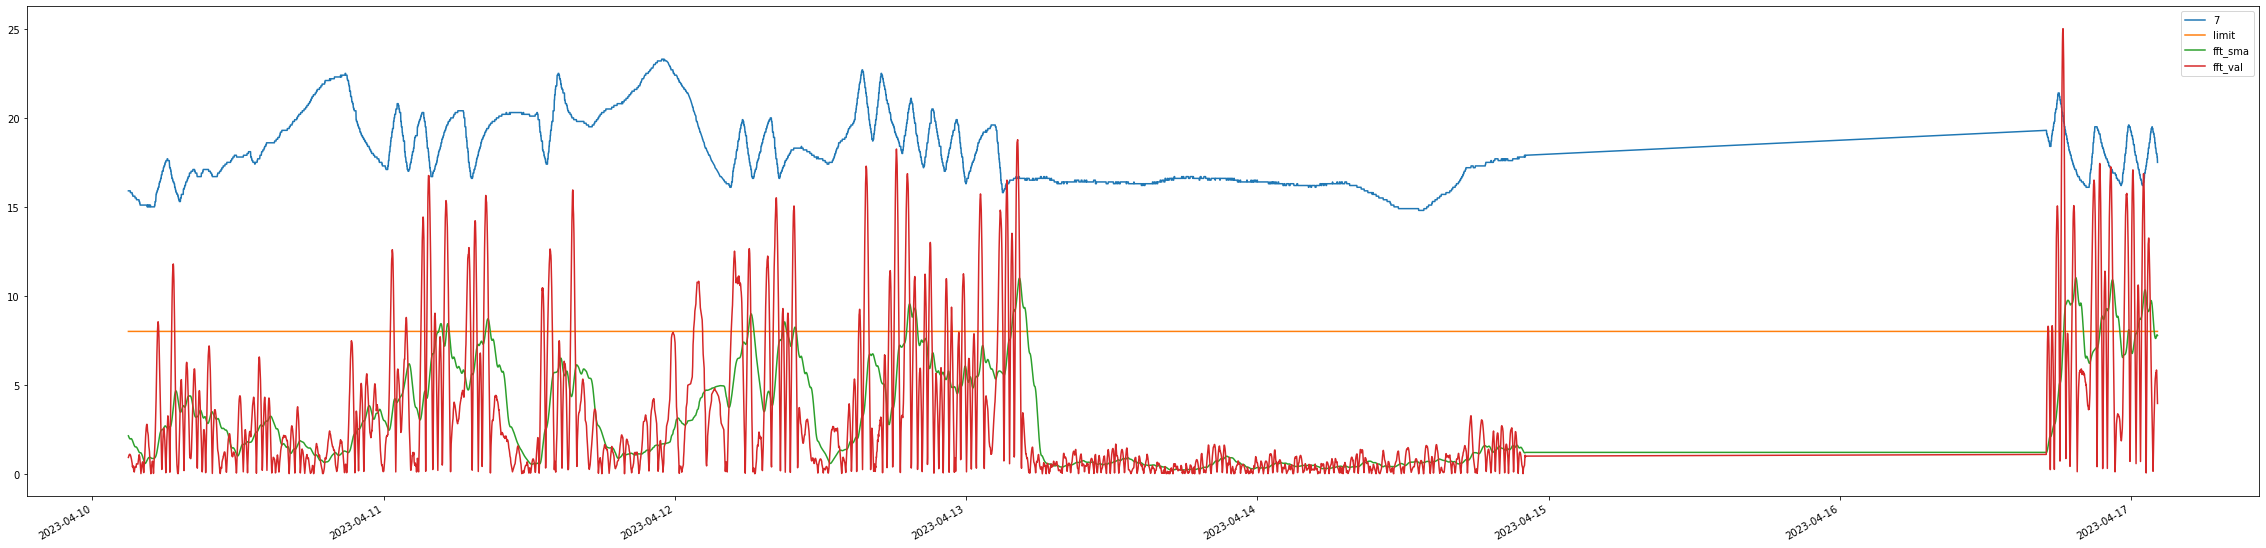

In [32]:
adf.iloc[800:8000].plot(kind='line',figsize=(40,10))

<AxesSubplot:>

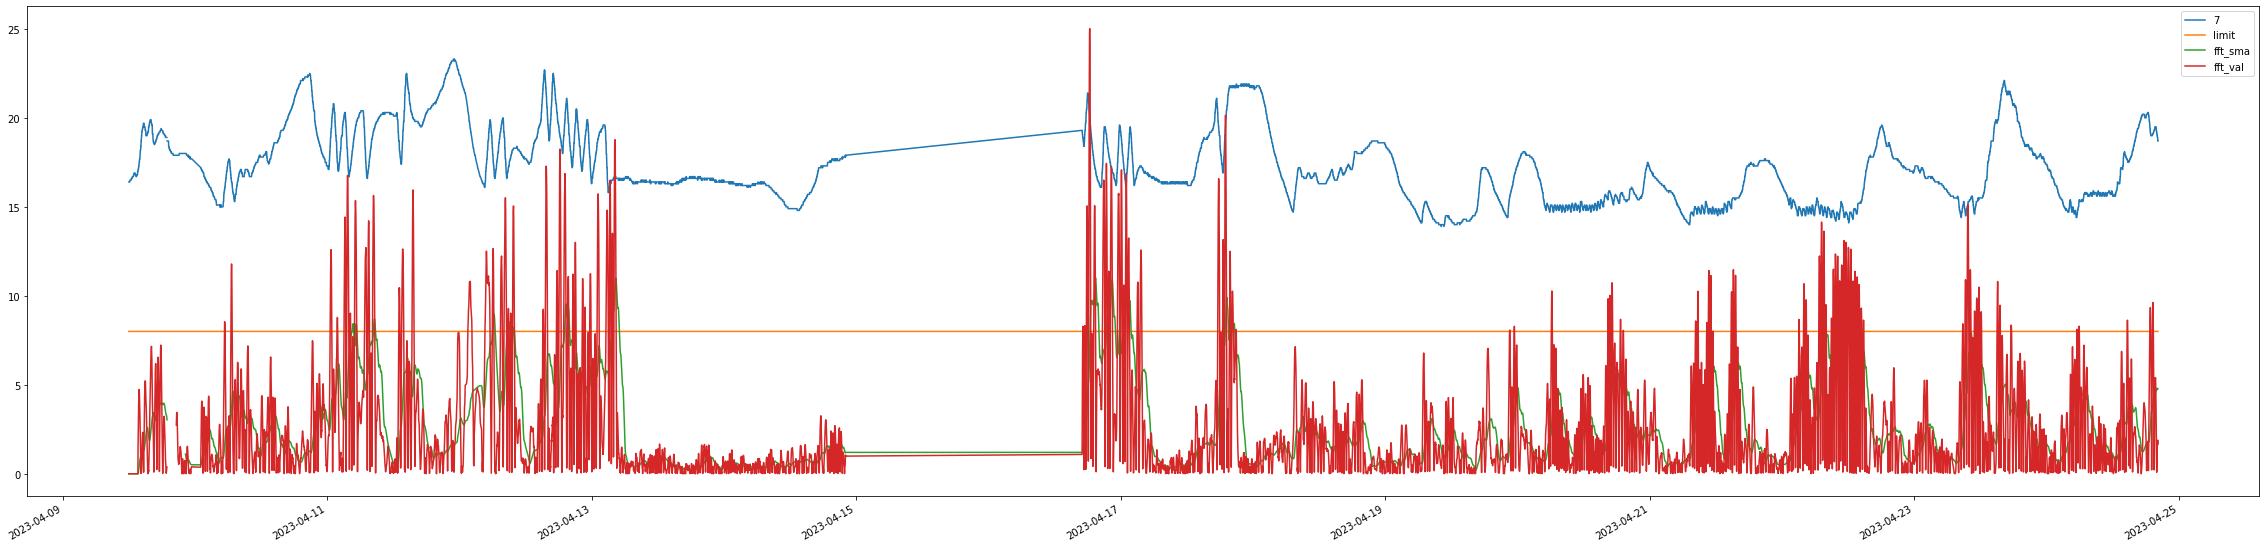

In [33]:
adf.plot(kind='line',figsize=(40,10))